# Permit-to-Occupancy in New York City

This notebook (along with files associated with it) examines the timeline of building construction to occupation in New York City.

## Introduction

### Construction Permit Process

Before a new building can begin construction it has to go through a long professional vetting process. The Department of Buildings (DOB) is the principal governmental organization responsible for overseeing the inspections and paperwork required for breaking ground. Once the construction permit has been issued and posted, work can begin.

### Certificate of Occupancy Process

The last step of new building construction is obtaining a certificate of occupancy ("C of O" for short). This document affirms that the building in question has been deemed to conform to the building code and is safe to occupy. 

A C of O is required for a building to be legally occupiable. DOB verifies with other coordinating agencies that all other outstanding requirements for the building have been satisfied before issuing the permit. Thus obtaining a C of O is the last step of the process in opening and occupying a building.

Most C of Os are permanent documents, however it is also possible to obtain an (expediated?) temporary document. Temporary C of Os have an expiration date, by which time a permanent document ought to have been granted. For our purposes we will treat them as equivalent documents.

### Retrieving Certificates of Occupancy

Certificates of Occupancy are publically available via the DOB [BIS interface](http://a810-bisweb.nyc.gov/bisweb/bsqpm01.jsp). This is an old interface and technically challenging to hook up to progammatically. Furthermore C of Os are stored as PDF documents, so access requires a pipeline for retrieving, loading, scanning, and parsing PDF text.

The `co_reader.py` module in this repository implements this capacity. For more technical notes on how that's done refer to that module's documentation.

### Retrieving Construction Permits

DOB releases a rolling list of all DOB construction permits filed as a publically accessible [dataset](https://data.cityofnewyork.us/Housing-Development/DOB-Permit-Issuance/ipu4-2q9a) on the New York City Open Data portal. Retrieving these permits is merely a matter of accessing, extracting, and filtering this dataset.

### Joining Permits to Certs

As expected, both the permits database and the certification pages are keyed by building `BIN`. However since the cert data requires a massive and long-running web scraping operation, the permit data is used as a base and the cert data is joined against it.

## Reading Construction Permit Data

The code below sets up our construction permit data.

In [1]:
import pandas as pd
import numpy as np
from __future__ import print_function

In [2]:
pd.set_option("max_columns", 500)

In [3]:
permits = pd.read_csv("DOB_Permit_Issuance.csv")

/Users/Honors/anaconda/envs/nyc-construction-timelines/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (1,8,9,11,12,31,51) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
permits.sample(3)

,BOROUGH,Bin #,House #,Street Name,Job #,Job doc. #,Job Type,Self_Cert,Block,Lot,Community Board,Zip Code,Bldg Type,Residential,Special District 1,Special District 2,Work Type,Permit Status,Filing Status,Permit Type,Permit Sequence #,Permit Subtype,Oil Gas,Site Fill,Filing Date,Issuance Date,Expiration Date,Job Start Date,Permittee's First Name,Permittee's Last Name,Permittee's Business Name,Permittee's Phone #,Permittee's License Type,Permittee's License #,Act as Superintendent,Permittee's Other Title,HIC License,Site Safety Mgr's First Name,Site Safety Mgr's Last Name,Site Safety Mgr Business Name,Superintendent First & Last Name,Superintendent Business Name,Owner's Business Type,Non-Profit,Owner's Business Name,Owner's First Name,Owner's Last Name,Owner's House #,Owner's House Street Name,Owner’s House City,Owner’s House State,Owner’s House Zip Code,Owner's Phone #,DOBRunDate
178502,BROOKLYN,3324728,868,PARK AVENUE,320989784.0,1.0,A3,Y,1580,1,303,11206,2,YES,NaN,NaN,EQ,ISSUED,RENEWAL,EQ,2.0,SH,,NaN,05/22/2014,05/22/2014 12:00:00 AM,05/22/2015,03/28/2014,JASWANT,SINGH,VIKRANT CONTRACTING & BUI,7182060125,GENERAL CONTRACTOR,0034878,,,,,,,,,NYCHA,NaN,NYCHA,MARTHA,BRAZOBAN,90,CHURCH STREET,NEW YORK,NY,10007,2123062810,05/23/2014 12:00:00 AM
409864,MANHATTAN,1.07719e+06,160REAR,ORCHARD ST.,140398601.0,1.0,A2,Y,411,8,103,10002,2,YES,NaN,NaN,OT,ISSUED,INITIAL,EW,1.0,OT,,NOT APPLICABLE,09/03/2015,09/03/2015 12:00:00 AM,02/23/2016,09/03/2015,HAKMAN,IEONG,KINSUN CONSTRUCTION CONSU,7.18267e+09,GENERAL CONTRACTOR,0606549,,,,,,,,,INDIVIDUAL,NaN,BROWNSTONE MANAGEMENT,ROHIT,SAMAI,88,RIVINGTON ST.,NEW YORK,NY,10022,2124756660,09/04/2015 12:00:00 AM
470189,STATEN ISLAND,5022314,130,VISTA AVE,520260609.0,1.0,A2,Y,859,25,502,10304,2,YES,NaN,NaN,OT,ISSUED,INITIAL,EW,1.0,OT,,NOT APPLICABLE,12/18/2015,12/18/2015 12:00:00 AM,08/27/2016,12/18/2015,LABIB,KRUNFOL,KRUNFOL & KRUNFOL CONS CO,9178254223,GENERAL CONTRACTOR,0614793,,,,,,,,,INDIVIDUAL,NaN,N/A,SALAH,ALRWHANI,130,VISTA AVE,STATEN ISLAND,NY,10304,9174995965,12/28/2015 12:00:00 AM


Non-obvious column keys:

* Bin # &mdash; Building Identification Number
* Job # &mdash; The number assigned to the job in the DOB system.
* Job doc # &mdash; A single job, if the job is of a sufficient level of complexity, can have multiple permits associated with it (when this occurs is unclear to me, however).

  These documents are all (almost?) always approved at the same time, so for our purposes we may safely take only Job doc # == 1.
* Job Type &mdash; We want specifically records with `Job Type=NB` as these are new building construction jobs.
* Permit Type &mdash; We want specifically records with `NB`, again.
* Self_Cert &mdash; Whether or not the job was professionally certified (at the cost of the owner; expedites the approval process).
* Bldg Type &mdash; Unsure what this is, but it seems to be unimportant. Only options are 1, 2, and (occassionally) an empty string.
* Permit Status &mdash; Whether the permit has been issued (usually), re-issued (occassionally), or is in process of being issued (rare, temporal).

  This appears to mean specifically the physical documents.

  For our purposes we only want original issuances.
* Filing Status &mdash; Whether the permit filed is a renewal or an initial filing.

  This appears to mean the actual permit document.
  
  Obviously we only want initial filings.
* Permit Sequence # &mdash; the number of the permit, in terms of how many times it has been renewed or perhaps re-requested. As expected, 'Filing Status'=='INITAL' implies that 'Permit Sequent #' == 1.0.
* Permit Subtype &mdash; Unknown, may be [building type](http://www.parkeronline.org/DocumentCenter/View/16233). Mostly left empty regardless.
* Oil Gas &mdash; Always empty.
* Site Fill &mdash; Apparent dirt movage. Very important to our audience! Will investigate further along.
* Filing Date &mdash; Date that the permit was approved.
* Expiration Date &mdash; Exactly one year less a day from the filing date.

In [5]:
permits['Permit Status'].value_counts()

ISSUED        553319
RE-ISSUED       3245
IN PROCESS        53
Name: Permit Status, dtype: int64

In [6]:
permits['Filing Status'].value_counts()

INITIAL    380733
RENEWAL    175884
Name: Filing Status, dtype: int64

In [7]:
permits['Job doc. #'].value_counts()

1.0     499793
2.0      44227
3.0      10095
4.0       1653
5.0        608
6.0        140
7.0         62
8.0         27
9.0         10
10.0         2
Name: Job doc. #, dtype: int64

Applying the restrictions noted in our exploration of the dataset nets us our new building permits.

In [8]:
new_building_permits = permits[(permits['Job Type'] == 'NB') &
                               (permits['Permit Type'] == 'NB') &
                               (permits['Permit Status'] == 'ISSUED') & 
                               (permits['Filing Status'] == 'INITIAL') &
                               (permits['Job doc. #'] == 1.0)]

In [9]:
len(permits)

556644

In [10]:
len(new_building_permits)

6819

The trouble is that this set is still not fully de-duped.

These entries appear to be seperate filing, each of which resulted in a construction permit being granted!

In [11]:
from collections import Counter
from tqdm import tqdm

In [12]:
cnt = 0
for _bin in tqdm(set(new_building_permits['Bin #'])):
    if len(new_building_permits[new_building_permits['Bin #'] == _bin]) > 1:
        cnt += 1
print(cnt)

100%|██████████| 6136/6136 [00:17<00:00, 348.15it/s]

567


Our timeline will need to accomodate the possibility of multiple permits. Up to how many?

In [13]:
counter = Counter()
for _bin in tqdm(set(new_building_permits['Bin #'])):
    nbp_l = len(new_building_permits[new_building_permits['Bin #'] == _bin])
    if nbp_l > 1:
        counter[nbp_l] += 1
counter

100%|██████████| 6136/6136 [00:12<00:00, 508.82it/s]


Counter({2: 521, 3: 21, 4: 18, 5: 1, 6: 2, 8: 1, 13: 1, 17: 1, 18: 1})

Let's simply take the date of the earliest one.

In [8]:
import arrow

In [9]:
import time

In [16]:
def select_earliest_permit(df):
    return df.iloc[np.argmin(df['Filing Date'].apply(lambda x: arrow.get(x,"MM/DD/YYYY")).values)]

In [17]:
list_by_bin = []
for _bin in tqdm(set(new_building_permits['Bin #'])):
    df = new_building_permits[new_building_permits['Bin #'] == _bin]
    if len(df) > 1:
        # print(select_earliest_permit(df))
        list_by_bin.append(select_earliest_permit(df))
        # time.sleep(1)
    else:
        list_by_bin.append(df.iloc[0])

100%|██████████| 6136/6136 [00:15<00:00, 400.80it/s]


This step took a long time to figure out. By default it concats Series into one super-Series, but axis=1 puts things in the wrong place index-wise, so I have to swap the indexes with `T` (transpose).

In [18]:
deduped_new_building_permits = pd.concat(list_by_bin, axis=1).T

In [20]:
deduped_new_building_permits['BOROUGH'].value_counts()

QUEENS           1898
BROOKLYN         1890
STATEN ISLAND    1566
BRONX             486
MANHATTAN         296
Name: BOROUGH, dtype: int64

In [21]:
borough_map = {
    'BROOKLYN': 'B',
    'QUEENS': 'Q',
    'STATEN ISLAND': 'R',
    'BRONX': 'X',
    'MANHATTAN': 'M'
}

In [22]:
deduped_new_building_permits.head(5)['Bin #']

26416         2818049
168380        4292627
131159        3833881
535342    2.09719e+06
544547        5144619
Name: Bin #, dtype: object

In [23]:
deduped_new_building_permits.head(1)

,BOROUGH,Bin #,House #,Street Name,Job #,Job doc. #,Job Type,Self_Cert,Block,Lot,Community Board,Zip Code,Bldg Type,Residential,Special District 1,Special District 2,Work Type,Permit Status,Filing Status,Permit Type,Permit Sequence #,Permit Subtype,Oil Gas,Site Fill,Filing Date,Issuance Date,Expiration Date,Job Start Date,Permittee's First Name,Permittee's Last Name,Permittee's Business Name,Permittee's Phone #,Permittee's License Type,Permittee's License #,Act as Superintendent,Permittee's Other Title,HIC License,Site Safety Mgr's First Name,Site Safety Mgr's Last Name,Site Safety Mgr Business Name,Superintendent First & Last Name,Superintendent Business Name,Owner's Business Type,Non-Profit,Owner's Business Name,Owner's First Name,Owner's Last Name,Owner's House #,Owner's House Street Name,Owner’s House City,Owner’s House State,Owner’s House Zip Code,Owner's Phone #,DOBRunDate
26416,BRONX,2818049,92,WEST TREMONT AVE,2.20177e+08,1,NB,NaN,2867,125,205,10453,2,YES,NaN,NaN,,ISSUED,INITIAL,NB,1,,,ON-SITE,06/21/2013,06/21/2013 12:00:00 AM,03/20/2014,06/21/2013,JIMMY,ZERVOUDIS,GALAXY G.C.GROUP LLC,7186017000,GENERAL CONTRACTOR,0610672,,,,,,,PHILIP ANTONAKOS,GALAXY GENERAL CONTRACTIO,HPD,Y,HOUSING PRESERVATION AND DEVELOP,TIMOTHY,JOSEPH,100,GOLD STREET,NEW YORK,NY,10038,2128637490,06/22/2013 12:00:00 AM


## Reading Certificate of Occupation Data&mdash;August 2013 Test Run

In order to validate assumptions about the data pipeline I used (arbitrarily selected) August 2013 permits as a month of interest.

In [7]:
import co_reader

In [24]:
august_2013_permits = deduped_new_building_permits[deduped_new_building_permits['Filing Date'].map(lambda x: arrow.get(x,"MM/DD/YYYY").month == 9 and arrow.get(x,"MM/DD/YYYY").year == 2013)]

In [25]:
len(august_2013_permits)

186

In [26]:
c_of_o_dict = dict()
counter = 0
for ind in tqdm((august_2013_permits).iterrows()):
    print("On loop {0}...".format(counter + 1))
    boro = ind[1]['BOROUGH']
    bin = ind[1]['Bin #']
    boro_code = borough_map[boro]
    c_of_o_dict[bin] = co_reader.get_co_date(bin, boro_code)
    counter += 1

0it [00:00, ?it/s]

On loop 1...
Requested BIN 4162303 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning Q000214797.PDF...
PDF Certificate of Occupancy 'Q000214797.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['01/14/2014', '01/14/2014', '01/14/2014']
Date(s) found!
Scanning Q000085427.PDF...
PDF Certificate of Occupancy 'Q000085427.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['01/14/2014', '01/14/2014', '01/14/2014']
Date(s) found!
Scanning 420825673.PDF...
PDF Certificate of Occupancy '420825673.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['01/14/2014', '01/14/2014', '01/14/2014']
Date(s) found!
Scanning 420825263.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420825263.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420825263.PDF' retrieved.
Copying text using op

1it [00:27, 27.85s/it]

['01/14/2014', '01/14/2014', '01/14/2014']
Date(s) found!
On loop 2...
Requested BIN 1082214 data from BIS, awaiting response...


2it [00:38, 22.66s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 3...
Requested BIN 5047261 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520147984F.PDF...
PDF Certificate of Occupancy '520147984F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


3it [00:51, 19.87s/it]

['11/25/2014', '01/29/2015', '11/25/2014', '01/29/2015']
Date(s) found!
On loop 4...
Requested BIN 2000570 data from BIS, awaiting response...
Got a response.
Discovered 5 Certificates of Occupancy.
Scanning 220192887F.PDF...
PDF Certificate of Occupancy '220192887F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['11/25/2014', '01/29/2015', '11/25/2014', '01/29/2015']
Date(s) found!
Scanning 220192887T002.PDF...
PDF Certificate of Occupancy '220192887T002.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['11/25/2014', '01/29/2015', '11/25/2014', '01/29/2015']
Date(s) found!
Scanning 220192887.PDF...
PDF Certificate of Occupancy '220192887.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['11/25/2014', '01/29/2015', '11/25/2014', '01/29/2015']
Date(s) found!
Scanning 220192887T001.PDF...
PDF Certificate of Occupancy '220192887T001.PDF' retrieved.
Copying text using opti

4it [01:14, 20.84s/it]

['11/25/2014', '01/29/2015', '11/25/2014', '01/29/2015']
Date(s) found!
On loop 5...
Requested BIN 4163416 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning Q000115527.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'Q000115527.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'Q000115527.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['03/09/2015', '03/09/2015', '06/07/2015', '06/07/2015']
Date(s) found!
Scanning 420849336T1.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420849336T1.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420849336T1.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['03/09/2015', '03/09/2015', '06/07/2015', '06/07/2015']
Date(s) found!
Scanning 420849345F.PDF...
PDF Certificate of Occupancy '420849345F.PDF' retriev

5it [01:58, 27.76s/it]

['03/09/2015', '03/09/2015', '06/07/2015', '06/07/2015']
Date(s) found!
On loop 6...
Requested BIN 2829340 data from BIS, awaiting response...


6it [02:09, 22.59s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 7...
Requested BIN 4163841 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420861482F.PDF...
PDF Certificate of Occupancy '420861482F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['07/14/2015', '07/14/2015', '07/14/2015']
Date(s) found!
Scanning 420861491.PDF...
PDF Certificate of Occupancy '420861491.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


7it [02:25, 20.62s/it]

['07/14/2015', '07/14/2015', '07/14/2015']
Date(s) found!
On loop 8...
Requested BIN 3410228 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320719585.PDF...
PDF Certificate of Occupancy '320719585.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


8it [02:39, 18.61s/it]

['07/14/2015', '07/14/2015', '07/14/2015']
Date(s) found!
On loop 9...
Requested BIN 4000093 data from BIS, awaiting response...


9it [02:49, 16.15s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 10...
Requested BIN 2829381 data from BIS, awaiting response...


10it [03:00, 14.42s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 11...
Requested BIN 1085940 data from BIS, awaiting response...


11it [03:10, 13.23s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 12...
Requested BIN 3807374 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning B000000790.PDF...
PDF Certificate of Occupancy 'B000000790.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['04/15/2015', '09/09/2015']
Date(s) found!
Scanning 320491115.PDF...
PDF Certificate of Occupancy '320491115.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


12it [03:26, 13.94s/it]

['04/15/2015', '09/09/2015']
Date(s) found!
On loop 13...
Requested BIN 4101093 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning Q000152898.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'Q000152898.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'Q000152898.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['05/20/2016', '05/20/2016']
Date(s) found!
Scanning 420856229.PDF...
PDF Certificate of Occupancy '420856229.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


13it [04:41, 32.49s/it]

['05/20/2016', '05/20/2016']
Date(s) found!
On loop 14...
Requested BIN 4134801 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420629270F.PDF...
PDF Certificate of Occupancy '420629270F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['09/26/2014']
Date(s) found!
Scanning 420814596F.PDF...
PDF Certificate of Occupancy '420814596F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


14it [04:55, 26.97s/it]

['09/26/2014']
Date(s) found!
On loop 15...
Requested BIN 5861035 data from BIS, awaiting response...


15it [05:06, 22.04s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 16...
Requested BIN 4593965 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420821025F.PDF...
PDF Certificate of Occupancy '420821025F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


16it [05:20, 19.65s/it]

['11/06/2015', '11/06/2015']
Date(s) found!
On loop 17...
Requested BIN 4004803 data from BIS, awaiting response...


17it [05:31, 16.94s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 18...
Requested BIN 4004953 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning Q000029501.PDF...
PDF Certificate of Occupancy 'Q000029501.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['04/25/2014', '04/25/2014', '04/25/2014']
Date(s) found!
Scanning Q000168574.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'Q000168574.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'Q000168574.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'Q000168574.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


18it [06:07, 22.68s/it]

[]
No date found. Continuing...
On loop 19...
Requested BIN 1088829 data from BIS, awaiting response...


19it [06:17, 19.06s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 20...
Requested BIN 4529910 data from BIS, awaiting response...


20it [06:28, 16.44s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 21...
Requested BIN 1089321 data from BIS, awaiting response...


21it [06:38, 14.63s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 22...
Requested BIN 4464467 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420887927.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420887927.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420887927.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420887927.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


22it [07:03, 17.78s/it]

[]
No date found. Continuing...
On loop 23...
Requested BIN 3088244 data from BIS, awaiting response...
Got a response.
Discovered 11 Certificates of Occupancy.
Scanning B000218282.PDF...
PDF Certificate of Occupancy 'B000218282.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000121583.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'B000121583.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'B000121583.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['08/21/2014']
Date(s) found!
Scanning B000204812.PDF...
PDF Certificate of Occupancy 'B000204812.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['08/21/2014']
Date(s) found!
Scanning B000225341.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'B000225341.PDF' again in five seconds...
After so

23it [08:29, 38.08s/it]

[]
No date found. Continuing...
On loop 24...
Requested BIN 3851635 data from BIS, awaiting response...


24it [08:40, 30.00s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 25...
Requested BIN 2072797 data from BIS, awaiting response...


25it [08:50, 24.12s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 26...
Requested BIN 3398417 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320514234.PDF...
PDF Certificate of Occupancy '320514234.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


26it [09:01, 20.26s/it]

[]
No date found. Continuing...
On loop 27...
Requested BIN 4465392 data from BIS, awaiting response...


27it [09:12, 17.31s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 28...
Requested BIN 4465824 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420884760F.PDF...
PDF Certificate of Occupancy '420884760F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


28it [09:25, 16.10s/it]

['04/06/2016', '04/06/2016']
Date(s) found!
On loop 29...
Requested BIN 4465850 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420870454.PDF...
PDF Certificate of Occupancy '420870454.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


29it [09:38, 15.23s/it]

['04/06/2016', '04/06/2016']
Date(s) found!
On loop 30...
Requested BIN 4466104 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 401446440.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '401446440.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '401446440.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420877858F.PDF...


30it [10:01, 17.46s/it]

PDF Certificate of Occupancy '420877858F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 31...
Requested BIN 4466176 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420885714F.PDF...
PDF Certificate of Occupancy '420885714F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


31it [10:12, 15.55s/it]

[]
No date found. Continuing...
On loop 32...
Requested BIN 4466513 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning Q000170483.PDF...
PDF Certificate of Occupancy 'Q000170483.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


32it [10:25, 14.87s/it]

['05/22/2014', '04/14/2015']
Date(s) found!
On loop 33...
Requested BIN 4466643 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420858423F.PDF...
PDF Certificate of Occupancy '420858423F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


33it [10:37, 13.76s/it]

[]
No date found. Continuing...
On loop 34...
Requested BIN 4466659 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420887909.PDF...
PDF Certificate of Occupancy '420887909.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


34it [10:47, 12.89s/it]

[]
No date found. Continuing...
On loop 35...
Requested BIN 4008028 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning 420795820T002.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420795820T002.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420795820T002.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420795820T002.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420795820.PDF...
PDF Certificate of Occupancy '420795820.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420795820T1.PDF...


35it [11:12, 16.45s/it]

PDF Certificate of Occupancy '420795820T1.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 36...
Requested BIN 4565110 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420838972F.PDF...
PDF Certificate of Occupancy '420838972F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420838838F.PDF...
PDF Certificate of Occupancy '420838838F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


36it [11:25, 15.24s/it]

[]
No date found. Continuing...
On loop 37...
Requested BIN 4565111 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420838963F.PDF...
PDF Certificate of Occupancy '420838963F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420838829F.PDF...
PDF Certificate of Occupancy '420838829F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


37it [11:36, 14.07s/it]

[]
No date found. Continuing...
On loop 38...
Requested BIN 4565115 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420605303.PDF...
PDF Certificate of Occupancy '420605303.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420605303TCO1.PDF...
PDF Certificate of Occupancy '420605303TCO1.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


38it [11:48, 13.32s/it]

[]
No date found. Continuing...
On loop 39...
Requested BIN 4040944 data from BIS, awaiting response...


39it [11:58, 12.44s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 40...
Requested BIN 3131104 data from BIS, awaiting response...


40it [12:08, 11.85s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 41...
Requested BIN 4467216 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420579662F.PDF...
PDF Certificate of Occupancy '420579662F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


41it [12:20, 11.82s/it]

[]
No date found. Continuing...
On loop 42...
Requested BIN 4008506 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning Q000198673.PDF...
PDF Certificate of Occupancy 'Q000198673.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000198677.PDF...


42it [12:31, 11.55s/it]

PDF Certificate of Occupancy 'Q000198677.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 43...
Requested BIN 2829339 data from BIS, awaiting response...


43it [12:41, 11.21s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 44...
Requested BIN 2829341 data from BIS, awaiting response...


44it [12:52, 10.97s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 45...
Requested BIN 2829342 data from BIS, awaiting response...


45it [13:02, 10.81s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 46...
Requested BIN 2829372 data from BIS, awaiting response...


46it [13:13, 10.66s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 47...
Requested BIN 2829374 data from BIS, awaiting response...


47it [13:23, 10.67s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 48...
Requested BIN 2829375 data from BIS, awaiting response...


48it [13:34, 10.56s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 49...
Requested BIN 2829376 data from BIS, awaiting response...


49it [13:44, 10.47s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 50...
Requested BIN 2829377 data from BIS, awaiting response...


50it [13:54, 10.45s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 51...
Requested BIN 2829378 data from BIS, awaiting response...


51it [14:05, 10.43s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 52...
Requested BIN 2829379 data from BIS, awaiting response...


52it [14:15, 10.42s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 53...
Requested BIN 2829380 data from BIS, awaiting response...


53it [14:25, 10.42s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 54...
Requested BIN 2829382 data from BIS, awaiting response...


54it [14:36, 10.38s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 55...
Requested BIN 2829383 data from BIS, awaiting response...


55it [14:46, 10.39s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 56...
Requested BIN 2829384 data from BIS, awaiting response...


56it [14:57, 10.43s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 57...
Requested BIN 2829385 data from BIS, awaiting response...


57it [15:07, 10.40s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 58...
Requested BIN 4305516 data from BIS, awaiting response...


58it [15:17, 10.37s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 59...
Requested BIN 3137429 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320719594.PDF...
PDF Certificate of Occupancy '320719594.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


59it [15:29, 10.75s/it]

[]
No date found. Continuing...
On loop 60...
Requested BIN 4141752 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning Q000086127.PDF...
PDF Certificate of Occupancy 'Q000086127.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


60it [15:41, 11.19s/it]

['09/09/2015', '09/09/2015', '11/10/2015', '11/10/2015']
Date(s) found!
On loop 61...
Requested BIN 2831362 data from BIS, awaiting response...


61it [15:52, 10.98s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 62...
Requested BIN 4306387 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning Q000096706.PDF...
PDF Certificate of Occupancy 'Q000096706.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['09/09/2015', '09/09/2015', '11/10/2015', '11/10/2015']
Date(s) found!
Scanning 420862016.PDF...
PDF Certificate of Occupancy '420862016.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['09/09/2015', '09/09/2015', '11/10/2015', '11/10/2015']
Date(s) found!
Scanning 420862016F.PDF...
PDF Certificate of Occupancy '420862016F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


62it [16:09, 12.87s/it]

['09/09/2015', '09/09/2015', '11/10/2015', '11/10/2015']
Date(s) found!
On loop 63...
Requested BIN 5158554 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520125588F.PDF...
PDF Certificate of Occupancy '520125588F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


63it [16:21, 12.58s/it]

['09/09/2015', '09/09/2015']
Date(s) found!
On loop 64...
Requested BIN 5158555 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520125604F.PDF...
PDF Certificate of Occupancy '520125604F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


64it [16:32, 12.22s/it]

[]
No date found. Continuing...
On loop 65...
Requested BIN 5158556 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning R000001922.PDF...
PDF Certificate of Occupancy 'R000001922.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning R000001482.PDF...
PDF Certificate of Occupancy 'R000001482.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 520125613F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520125613F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520125613F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


65it [16:55, 15.31s/it]

['09/03/2015']
Date(s) found!
On loop 66...
Requested BIN 4863747 data from BIS, awaiting response...


66it [17:05, 13.84s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 67...
Requested BIN 4044745 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420824255.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420824255.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420824255.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420824255.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


67it [17:29, 16.91s/it]

['09/03/2015', '09/03/2015']
Date(s) found!
On loop 68...
Requested BIN 5158989 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113840F.PDF...
PDF Certificate of Occupancy '520113840F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


68it [17:43, 15.93s/it]

['08/28/2015', '08/28/2015', '08/28/2015']
Date(s) found!
On loop 69...
Requested BIN 5159056 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113546F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520113546F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520113546F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


69it [18:01, 16.59s/it]

['04/30/2014', '04/30/2014', '04/30/2014']
Date(s) found!
On loop 70...
Requested BIN 5159058 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113528F.PDF...
PDF Certificate of Occupancy '520113528F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


70it [18:14, 15.53s/it]

['01/14/2014', '01/14/2014', '01/14/2014']
Date(s) found!
On loop 71...
Requested BIN 5159059 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113519F.PDF...
PDF Certificate of Occupancy '520113519F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


71it [18:26, 14.40s/it]

['01/14/2014', '01/14/2014', '01/14/2014']
Date(s) found!
On loop 72...
Requested BIN 5159060 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113500F.PDF...
PDF Certificate of Occupancy '520113500F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


72it [18:38, 13.82s/it]

['01/14/2014', '01/14/2014', '01/14/2014']
Date(s) found!
On loop 73...
Requested BIN 5159061 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113494F.PDF...
PDF Certificate of Occupancy '520113494F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


73it [18:51, 13.35s/it]

['12/31/2013', '12/31/2013', '12/31/2013', '12/31/2013']
Date(s) found!
On loop 74...
Requested BIN 5159118 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113831F.PDF...
PDF Certificate of Occupancy '520113831F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


74it [19:08, 14.44s/it]

['01/14/2014', '01/14/2014', '01/14/2014']
Date(s) found!
On loop 75...
Requested BIN 5159119 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113822F.PDF...
PDF Certificate of Occupancy '520113822F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


75it [19:20, 13.72s/it]

['04/30/2014', '04/30/2014', '04/30/2014']
Date(s) found!
On loop 76...
Requested BIN 5159120 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113813F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520113813F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520113813F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


76it [19:40, 15.63s/it]

['04/30/2014', '04/30/2014', '04/30/2014']
Date(s) found!
On loop 77...
Requested BIN 5159129 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113804F.PDF...
PDF Certificate of Occupancy '520113804F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


77it [19:53, 14.82s/it]

['04/30/2014', '04/30/2014', '04/30/2014']
Date(s) found!
On loop 78...
Requested BIN 5159130 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113797F.PDF...
PDF Certificate of Occupancy '520113797F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


78it [20:05, 14.01s/it]

['06/05/2014', '06/05/2014']
Date(s) found!
On loop 79...
Requested BIN 5159131 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113788F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520113788F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520113788F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


79it [20:25, 15.76s/it]

['04/30/2014', '04/30/2014', '04/30/2014']
Date(s) found!
On loop 80...
Requested BIN 5159132 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113779F.PDF...
PDF Certificate of Occupancy '520113779F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


80it [20:38, 15.04s/it]

['04/30/2014', '04/30/2014', '04/30/2014']
Date(s) found!
On loop 81...
Requested BIN 5159133 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113760F.PDF...
PDF Certificate of Occupancy '520113760F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


81it [20:51, 14.52s/it]

['04/30/2014', '04/30/2014', '04/30/2014']
Date(s) found!
On loop 82...
Requested BIN 5159134 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113751F.PDF...
PDF Certificate of Occupancy '520113751F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


82it [21:04, 14.10s/it]

['04/11/2014', '04/11/2014', '04/11/2014']
Date(s) found!
On loop 83...
Requested BIN 4864530 data from BIS, awaiting response...


83it [21:15, 13.16s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 84...
Requested BIN 3062376 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320545362.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320545362.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320545362.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320545362.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


84it [21:39, 16.27s/it]

['04/15/2014', '04/15/2014', '04/15/2014']
Date(s) found!
On loop 85...
Requested BIN 5159614 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 500520117F.PDF...
PDF Certificate of Occupancy '500520117F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['09/11/2015', '09/11/2015', '09/11/2015']
Date(s) found!
Scanning 500520117F.PDF...
PDF Certificate of Occupancy '500520117F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


85it [21:55, 16.10s/it]

['09/11/2015', '09/11/2015', '09/11/2015']
Date(s) found!
On loop 86...
Requested BIN 2800767 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 220246240T001.PDF...
PDF Certificate of Occupancy '220246240T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


86it [22:07, 14.91s/it]

['09/11/2015', '09/11/2015', '09/11/2015']
Date(s) found!
On loop 87...
Requested BIN 4865460 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420291534.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420291534.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420291534.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


87it [22:25, 15.91s/it]

['05/19/2016', '05/19/2016', '08/17/2016', '08/17/2016', '15/19/2016']
No date found. Continuing...
On loop 88...
Requested BIN 4865462 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420291525.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420291525.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420291525.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


88it [22:43, 16.65s/it]

['01/19/2016', '01/19/2016', '01/19/2016']
Date(s) found!
On loop 89...
Requested BIN 5029412 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520145334F.PDF...
PDF Certificate of Occupancy '520145334F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


89it [22:56, 15.34s/it]

['01/21/2016', '01/21/2016', '01/21/2016']
Date(s) found!
On loop 90...
Requested BIN 3063353 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320375651.PDF...
PDF Certificate of Occupancy '320375651.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


90it [23:08, 14.53s/it]

['09/11/2014', '09/11/2014', '09/11/2014']
Date(s) found!
On loop 91...
Requested BIN 4538134 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420534372.PDF...
PDF Certificate of Occupancy '420534372.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['05/07/2015', '05/07/2015']
Date(s) found!
Scanning 420534372T1.PDF...
PDF Certificate of Occupancy '420534372T1.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


91it [23:23, 14.71s/it]

['05/07/2015', '05/07/2015']
Date(s) found!
On loop 92...
Requested BIN 4538167 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420778741F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420778741F.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420778741F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420778741F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


92it [23:47, 17.52s/it]

['07/01/2015', '07/01/2015', '09/29/2015', '09/29/2015']
Date(s) found!
On loop 93...
Requested BIN 5816196 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 520144567F.PDF...
PDF Certificate of Occupancy '520144567F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['04/03/2015', '04/03/2015']
Date(s) found!
Scanning 520180740F.PDF...
PDF Certificate of Occupancy '520180740F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


93it [24:01, 16.42s/it]

['04/03/2015', '04/03/2015']
Date(s) found!
On loop 94...
Requested BIN 3325861 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning B000214031.PDF...
PDF Certificate of Occupancy 'B000214031.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['01/25/2016', '01/25/2016']
Date(s) found!
Scanning B000113318.PDF...
PDF Certificate of Occupancy 'B000113318.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['01/25/2016', '01/25/2016']
Date(s) found!
Scanning B000214031.PDF...
PDF Certificate of Occupancy 'B000214031.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


94it [24:18, 16.63s/it]

['01/25/2016', '01/25/2016']
Date(s) found!
On loop 95...
Requested BIN 5062667 data from BIS, awaiting response...


95it [24:29, 14.79s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 96...
Requested BIN 4571598 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420856336F.PDF...
PDF Certificate of Occupancy '420856336F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['01/25/2016', '01/25/2016']
Date(s) found!
Scanning 420856121F.PDF...
PDF Certificate of Occupancy '420856121F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


96it [24:47, 15.68s/it]

['01/25/2016', '01/25/2016']
Date(s) found!
On loop 97...
Requested BIN 2016152 data from BIS, awaiting response...


97it [24:57, 14.16s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 98...
Requested BIN 5161894 data from BIS, awaiting response...


98it [25:08, 13.06s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 99...
Requested BIN 3851222 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320529530.PDF...
PDF Certificate of Occupancy '320529530.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


99it [25:23, 13.80s/it]

['06/11/2014', '06/11/2014', '06/11/2014']
Date(s) found!
On loop 100...
Requested BIN 2016441 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning 220232175T001.PDF...
PDF Certificate of Occupancy '220232175T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['06/11/2014', '06/11/2014', '06/11/2014']
Date(s) found!
Scanning 220232175T003.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '220232175T003.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '220232175T003.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['03/02/2015', '03/17/2016', '05/31/2015', '03/17/2016']
Date(s) found!
Scanning 220232175T004.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '220232175T004.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '220232175T004.PDF' retrieved.
C

100it [26:09, 23.36s/it]

['03/02/2015', '03/17/2016', '05/31/2015', '03/17/2016']
Date(s) found!
On loop 101...
Requested BIN 5162170 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520148386F.PDF...
PDF Certificate of Occupancy '520148386F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


101it [26:23, 20.63s/it]

['06/11/2015', '06/11/2015', '09/09/2015', '09/09/2015', '26/11/2015']
No date found. Continuing...
On loop 102...
Requested BIN 5162171 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520148395F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520148395F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520148395F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


102it [26:43, 20.31s/it]

['09/25/2014', '09/25/2014', '09/25/2014']
Date(s) found!
On loop 103...
Requested BIN 5162176 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520144193F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520144193F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520144193F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


103it [27:03, 20.31s/it]

['07/17/2014', '07/17/2014', '07/17/2014']
Date(s) found!
On loop 104...
Requested BIN 5162207 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520148402F.PDF...
PDF Certificate of Occupancy '520148402F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


104it [27:16, 18.01s/it]

['05/02/2014', '05/02/2014']
Date(s) found!
On loop 105...
Requested BIN 5162208 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520148411F.PDF...
PDF Certificate of Occupancy '520148411F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


105it [27:28, 16.25s/it]

['08/07/2014', '08/07/2014']
Date(s) found!
On loop 106...
Requested BIN 5162334 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520147305F.PDF...
PDF Certificate of Occupancy '520147305F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


106it [27:41, 15.43s/it]

['09/12/2014', '09/12/2014', '09/12/2014']
Date(s) found!
On loop 107...
Requested BIN 5162529 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning 520145290F.PDF...
PDF Certificate of Occupancy '520145290F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['03/25/2014', '03/25/2014', '03/25/2014']
Date(s) found!
Scanning 520145307F.PDF...
PDF Certificate of Occupancy '520145307F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['03/25/2014', '03/25/2014', '03/25/2014']
Date(s) found!
Scanning 520145290F.PDF...
PDF Certificate of Occupancy '520145290F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['03/25/2014', '03/25/2014', '03/25/2014']
Date(s) found!
Scanning 520145307F.PDF...
PDF Certificate of Occupancy '520145307F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


107it [28:01, 16.55s/it]

['03/25/2014', '03/25/2014', '03/25/2014']
Date(s) found!
On loop 108...
Requested BIN 3819111 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning B000089988.PDF...
PDF Certificate of Occupancy 'B000089988.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['11/20/2014', '11/20/2014', '11/20/2014', '11/20/2014']
Date(s) found!
Scanning 320529549.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320529549.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320529549.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


108it [28:22, 18.05s/it]

['11/20/2014', '11/20/2014', '11/20/2014', '11/20/2014']
Date(s) found!
On loop 109...
Requested BIN 3131134 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning B000211963.PDF...
PDF Certificate of Occupancy 'B000211963.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 320723473.PDF...
PDF Certificate of Occupancy '320723473.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


109it [28:34, 16.33s/it]

[]
No date found. Continuing...
On loop 110...
Requested BIN 5857603 data from BIS, awaiting response...


110it [28:45, 14.61s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 111...
Requested BIN 4212792 data from BIS, awaiting response...


111it [28:56, 13.45s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 112...
Requested BIN 4442276 data from BIS, awaiting response...
Got a response.
Discovered 5 Certificates of Occupancy.
Scanning Q000193710.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'Q000193710.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'Q000193710.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['02/16/2016', '02/16/2016']
Date(s) found!
Scanning 420603644TCO1.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420603644TCO1.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420603644TCO1.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420603644TCO1.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420603644TCO1.PDF' retrieved.
Copying text using optical c

112it [29:56, 27.46s/it]

['02/16/2016', '02/16/2016']
Date(s) found!
On loop 113...
Requested BIN 3000634 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning B000115640.PDF...
PDF Certificate of Occupancy 'B000115640.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['02/16/2016', '02/16/2016']
Date(s) found!
Scanning B000194265.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'B000194265.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'B000194265.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['02/11/2016', '32/11/2016']
No date found. Continuing...
Scanning 320375991-01.PDF...
PDF Certificate of Occupancy '320375991-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


113it [30:28, 28.92s/it]

['02/11/2016', '32/11/2016']
No date found. Continuing...
On loop 114...
Requested BIN 5163451 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520147993F.PDF...
PDF Certificate of Occupancy '520147993F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


114it [30:43, 24.76s/it]

['02/11/2016', '32/11/2016']
No date found. Continuing...
On loop 115...
Requested BIN 4541524 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420534381F.PDF...
PDF Certificate of Occupancy '420534381F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['04/15/2015', '05/25/2016', '07/25/2016', '15/25/2016']
No date found. Continuing...
Scanning 420534381T1.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420534381T1.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420534381T1.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420534381T1.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


115it [31:12, 26.09s/it]

['04/15/2015', '05/25/2016', '07/25/2016', '15/25/2016']
No date found. Continuing...
On loop 116...
Requested BIN 2832138 data from BIS, awaiting response...


116it [31:23, 21.51s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 117...
Requested BIN 5164082 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520145343F.PDF...
PDF Certificate of Occupancy '520145343F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


117it [31:36, 18.96s/it]

['07/01/2015', '10/15/2015', '09/29/2015', '10/21/2015']
Date(s) found!
On loop 118...
Requested BIN 4541577 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning Q000192971.PDF...
PDF Certificate of Occupancy 'Q000192971.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


118it [31:50, 17.28s/it]

['09/11/2014', '09/11/2014', '09/11/2014']
Date(s) found!
On loop 119...
Requested BIN 4541630 data from BIS, awaiting response...


119it [32:00, 15.29s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 120...
Requested BIN 3853611 data from BIS, awaiting response...


120it [32:11, 13.85s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 121...
Requested BIN 4214980 data from BIS, awaiting response...


121it [32:21, 12.86s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 122...
Requested BIN 4214981 data from BIS, awaiting response...


122it [32:33, 12.40s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 123...
Requested BIN 4542663 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning 420605651TCO3.PDF...
PDF Certificate of Occupancy '420605651TCO3.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420605651T1.PDF...
PDF Certificate of Occupancy '420605651T1.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420605651T005.PDF...
PDF Certificate of Occupancy '420605651T005.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


123it [32:45, 12.44s/it]

[]
No date found. Continuing...
On loop 124...
Requested BIN 4542669 data from BIS, awaiting response...


124it [32:56, 11.87s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 125...
Requested BIN 4542710 data from BIS, awaiting response...


125it [33:07, 11.57s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 126...
Requested BIN 5158980 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520110291F.PDF...
PDF Certificate of Occupancy '520110291F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


126it [33:19, 11.83s/it]

[]
No date found. Continuing...
On loop 127...
Requested BIN 4542912 data from BIS, awaiting response...


127it [33:30, 11.50s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 128...
Requested BIN 5159057 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113537F.PDF...
PDF Certificate of Occupancy '520113537F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


128it [33:45, 12.53s/it]

['07/31/2014', '05/26/2016', '08/24/2016']
Date(s) found!
On loop 129...
Requested BIN 4117462 data from BIS, awaiting response...
Got a response.


129it [33:56, 12.06s/it]

Discovered 0 Certificates of Occupancy.
On loop 130...
Requested BIN 4543773 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420840594F.PDF...
PDF Certificate of Occupancy '420840594F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['01/14/2014', '01/14/2014', '01/14/2014']
Date(s) found!
Scanning 420814364F.PDF...
PDF Certificate of Occupancy '420814364F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


130it [34:11, 13.07s/it]

['01/14/2014', '01/14/2014', '01/14/2014']
Date(s) found!
On loop 131...
Requested BIN 2119001 data from BIS, awaiting response...


131it [34:22, 12.36s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 132...
Requested BIN 3856360 data from BIS, awaiting response...


132it [34:33, 11.91s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 133...
Requested BIN 4544604 data from BIS, awaiting response...


133it [34:43, 11.58s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 134...
Requested BIN 3398118 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320513191.PDF...
PDF Certificate of Occupancy '320513191.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


134it [34:58, 12.32s/it]

['06/18/2015', '06/18/2015', '06/18/2015']
Date(s) found!
On loop 135...
Requested BIN 3398258 data from BIS, awaiting response...


135it [35:08, 11.84s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 136...
Requested BIN 3398374 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 320507778.PDF...
PDF Certificate of Occupancy '320507778.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['06/24/2014', '06/24/2014', '06/24/2014']
Date(s) found!
Scanning 320507778-01.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320507778-01.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320507778-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


136it [35:29, 14.37s/it]

['06/24/2014', '06/24/2014', '06/24/2014']
Date(s) found!
On loop 137...
Requested BIN 3398375 data from BIS, awaiting response...


137it [35:39, 13.24s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 138...
Requested BIN 3398428 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320467945.PDF...
PDF Certificate of Occupancy '320467945.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


138it [35:51, 12.98s/it]

['01/07/2016', '01/07/2016', '04/06/2016', '04/06/2016']
Date(s) found!
On loop 139...
Requested BIN 3398449 data from BIS, awaiting response...


139it [36:02, 12.23s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 140...
Requested BIN 1039598 data from BIS, awaiting response...


140it [36:12, 11.69s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 141...
Requested BIN 3399064 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320516465.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320516465.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320516465.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


141it [36:32, 13.99s/it]

['04/20/2016', '04/20/2016', '04/20/2016']
Date(s) found!
On loop 142...
Requested BIN 3399065 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320516492.PDF...
PDF Certificate of Occupancy '320516492.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


142it [36:45, 13.70s/it]

['08/20/2015', '08/20/2015', '08/20/2015']
Date(s) found!
On loop 143...
Requested BIN 3399066 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320516483.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320516483.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320516483.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


143it [37:03, 14.94s/it]

['08/28/2015', '08/28/2015', '08/28/2015']
Date(s) found!
On loop 144...
Requested BIN 3399067 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320516474.PDF...
PDF Certificate of Occupancy '320516474.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


144it [37:16, 14.35s/it]

['08/20/2015', '08/20/2015', '08/20/2015']
Date(s) found!
On loop 145...
Requested BIN 2055853 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning X000041777.PDF...
PDF Certificate of Occupancy 'X000041777.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


145it [37:27, 13.60s/it]

['08/27/2015', '08/27/2015', '08/27/2015']
Date(s) found!
On loop 146...
Requested BIN 4120329 data from BIS, awaiting response...


146it [37:38, 12.69s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 147...
Requested BIN 3182609 data from BIS, awaiting response...


147it [37:49, 12.15s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 148...
Requested BIN 5857593 data from BIS, awaiting response...


148it [38:00, 11.83s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 149...
Requested BIN 5857594 data from BIS, awaiting response...


149it [38:11, 11.48s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 150...
Requested BIN 5857595 data from BIS, awaiting response...


150it [38:23, 11.73s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 151...
Requested BIN 5857596 data from BIS, awaiting response...


151it [38:34, 11.42s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 152...
Requested BIN 5857597 data from BIS, awaiting response...


152it [38:45, 11.25s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 153...
Requested BIN 5857598 data from BIS, awaiting response...


153it [38:56, 11.41s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 154...
Requested BIN 5857599 data from BIS, awaiting response...


154it [39:07, 11.29s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 155...
Requested BIN 5857600 data from BIS, awaiting response...


155it [39:18, 11.18s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 156...
Requested BIN 5857601 data from BIS, awaiting response...


156it [39:29, 10.99s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 157...
Requested BIN 5857602 data from BIS, awaiting response...


157it [39:39, 10.88s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 158...
Requested BIN 4547155 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning 410028312.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '410028312.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '410028312.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '410028312.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 410028312T1.PDF...
PDF Certificate of Occupancy '410028312T1.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420817147.PDF...
PDF Certificate of Occupancy '420817147.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


158it [40:06, 15.57s/it]

[]
No date found. Continuing...
On loop 159...
Requested BIN 4547156 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning 410028303F.PDF...
PDF Certificate of Occupancy '410028303F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['08/12/2014', '08/12/2014', '08/12/2014']
Date(s) found!
Scanning 410028303TCO1.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '410028303TCO1.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '410028303TCO1.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '410028303TCO1.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['08/12/2014', '08/12/2014', '08/12/2014']
Date(s) found!
Scanning 420817138F.PDF...
PDF Certificate of Occupancy '420817138F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...

159it [40:33, 19.03s/it]

['08/12/2014', '08/12/2014', '08/12/2014']
Date(s) found!
On loop 160...
Requested BIN 4121353 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420809664.PDF...
PDF Certificate of Occupancy '420809664.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['08/12/2014', '08/12/2014', '08/12/2014']
Date(s) found!
Scanning 420827181.PDF...
PDF Certificate of Occupancy '420827181.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


160it [40:46, 17.36s/it]

['08/12/2014', '08/12/2014', '08/12/2014']
Date(s) found!
On loop 161...
Requested BIN 3220959 data from BIS, awaiting response...


161it [40:57, 15.42s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 162...
Requested BIN 5858114 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520094576F.PDF...
PDF Certificate of Occupancy '520094576F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


162it [41:11, 14.78s/it]

['09/25/2014', '09/25/2014', '09/25/2014']
Date(s) found!
On loop 163...
Requested BIN 5858115 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520094585F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520094585F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520094585F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


163it [41:29, 15.75s/it]

['10/16/2014', '10/16/2014', '10/16/2014', '10/16/2014']
Date(s) found!
On loop 164...
Requested BIN 5858116 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520094594F.PDF...
PDF Certificate of Occupancy '520094594F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


164it [41:41, 14.58s/it]

['02/05/2015', '02/05/2015']
Date(s) found!
On loop 165...
Requested BIN 5034136 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning R000033235.PDF...
PDF Certificate of Occupancy 'R000033235.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['03/30/2015', '03/30/2015', '03/30/2015']
Date(s) found!
Scanning R500380483.PDF...
PDF Certificate of Occupancy 'R500380483.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


165it [41:56, 14.73s/it]

['03/30/2015', '03/30/2015', '03/30/2015']
Date(s) found!
On loop 166...
Requested BIN 5858216 data from BIS, awaiting response...


166it [42:06, 13.55s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 167...
Requested BIN 3827132 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320756151.PDF...
PDF Certificate of Occupancy '320756151.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


167it [42:21, 13.80s/it]

[]
No date found. Continuing...
On loop 168...
Requested BIN 4105868 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning Q000057699.PDF...
PDF Certificate of Occupancy 'Q000057699.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['08/12/2014', '08/12/2014']
Date(s) found!
Scanning 420805597F.PDF...
PDF Certificate of Occupancy '420805597F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


168it [42:37, 14.67s/it]

['08/12/2014', '08/12/2014']
Date(s) found!
On loop 169...
Requested BIN 3140067 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning B000094805.PDF...
PDF Certificate of Occupancy 'B000094805.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['08/12/2014', '08/12/2014']
Date(s) found!
Scanning 320742381.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320742381.PDF' again in five seconds...


169it [42:59, 16.61s/it]

After some delay, PDF Certificate of Occupancy '320742381.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 170...
Requested BIN 4221547 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning Q000088592.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'Q000088592.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'Q000088592.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'Q000088592.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'Q000088592.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


170it [43:42, 24.70s/it]

['07/21/2015', '07/21/2015', '07/21/2015']
Date(s) found!
On loop 171...
Requested BIN 3107718 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning B000230624.PDF...
PDF Certificate of Occupancy 'B000230624.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


171it [43:56, 21.53s/it]

['07/21/2015', '07/21/2015', '07/21/2015']
Date(s) found!
On loop 172...
Requested BIN 5860463 data from BIS, awaiting response...


172it [44:07, 18.26s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 173...
Requested BIN 5860484 data from BIS, awaiting response...


173it [44:18, 15.97s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 174...
Requested BIN 3402929 data from BIS, awaiting response...


174it [44:28, 14.37s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 175...
Requested BIN 3402993 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320756160.PDF...
PDF Certificate of Occupancy '320756160.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


175it [44:40, 13.53s/it]

[]
No date found. Continuing...
On loop 176...
Requested BIN 5861033 data from BIS, awaiting response...


176it [44:50, 12.68s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 177...
Requested BIN 5861034 data from BIS, awaiting response...


177it [45:02, 12.26s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 178...
Requested BIN 5041922 data from BIS, awaiting response...


178it [45:12, 11.74s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 179...
Requested BIN 5861663 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520161128F.PDF...
PDF Certificate of Occupancy '520161128F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


179it [45:25, 12.05s/it]

['08/01/2014', '08/01/2014']
Date(s) found!
On loop 180...
Requested BIN 1078240 data from BIS, awaiting response...
Got a response.
Discovered 7 Certificates of Occupancy.
Scanning M000012721.PDF...
PDF Certificate of Occupancy 'M000012721.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['02/19/2016', '02/19/2016', '02/19/2016']
Date(s) found!
Scanning M000014373.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'M000014373.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'M000014373.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'M000014373.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['02/19/2016', '02/19/2016', '02/19/2016']
Date(s) found!
Scanning M000014638.PDF...
PDF Certificate of Occupancy 'M000014638.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...

180it [46:22, 25.52s/it]

['02/19/2016', '02/19/2016', '02/19/2016']
Date(s) found!
On loop 181...
Requested BIN 4155560 data from BIS, awaiting response...


181it [46:33, 21.07s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 182...
Requested BIN 4224102 data from BIS, awaiting response...


182it [46:44, 18.07s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 183...
Requested BIN 5863056 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520094601F.PDF...
PDF Certificate of Occupancy '520094601F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


183it [47:03, 18.33s/it]

['02/19/2016', '02/19/2016', '02/19/2016']
Date(s) found!
On loop 184...
Requested BIN 5044235 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520125597F.PDF...
PDF Certificate of Occupancy '520125597F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


184it [47:22, 18.55s/it]

['02/19/2016', '02/19/2016', '02/19/2016']
Date(s) found!
On loop 185...
Requested BIN 4159853 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420621456F.PDF...
PDF Certificate of Occupancy '420621456F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


185it [47:41, 18.77s/it]

['02/19/2016', '02/19/2016', '02/19/2016']
Date(s) found!
On loop 186...
Requested BIN 1080831 data from BIS, awaiting response...
Got a response.
Discovered 6 Certificates of Occupancy.
Scanning M000074762.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'M000074762.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'M000074762.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['07/15/2014']
Date(s) found!
Scanning 121325495-02.PDF...
PDF Certificate of Occupancy '121325495-02.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['07/15/2014']
Date(s) found!
Scanning 121325495-05.PDF...
PDF Certificate of Occupancy '121325495-05.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['07/15/2014']
Date(s) found!
Scanning 121325495-04.PDF...
PDF Certificate of Occupancy '121325495-04.PDF' retrieved.
Copying text using optical c

186it [48:46, 32.53s/it]

['07/15/2014']
Date(s) found!


In [29]:
c_of_o_dict

{1039598: None,
 1078240: datetime.datetime(2016, 2, 19, 0, 0, tzinfo=tzutc()),
 1080831: datetime.datetime(2014, 7, 15, 0, 0, tzinfo=tzutc()),
 1082214: None,
 1085940: None,
 1088829: None,
 1089321: None,
 2000570: datetime.datetime(2014, 11, 25, 0, 0, tzinfo=tzutc()),
 2016152: None,
 2016441: datetime.datetime(2015, 3, 2, 0, 0, tzinfo=tzutc()),
 2055853: datetime.datetime(2015, 8, 27, 0, 0, tzinfo=tzutc()),
 2072797: None,
 2119001: None,
 2800767: datetime.datetime(2015, 9, 11, 0, 0, tzinfo=tzutc()),
 2829339: None,
 2829340: None,
 2829341: None,
 2829342: None,
 2829372: None,
 2829374: None,
 2829375: None,
 2829376: None,
 2829377: None,
 2829378: None,
 2829379: None,
 2829380: None,
 2829381: None,
 2829382: None,
 2829383: None,
 2829384: None,
 2829385: None,
 2831362: None,
 2832138: None,
 3000634: datetime.datetime(2016, 2, 16, 0, 0, tzinfo=tzutc()),
 3062376: datetime.datetime(2014, 4, 15, 0, 0, tzinfo=tzutc()),
 3063353: datetime.datetime(2014, 9, 11, 0, 0, tzinfo=tz

In [35]:
len([date for (bin, date) in c_of_o_dict.items() if date != None])

85

### Data validation check

186 new building construction permits were issued in August 2013. As of late June 2016, 85 of these have corresponding certificates of occupancy on record. This correspondgs with a `85/186 = ~45%` completion rate.

85*12=1020, so this data implies that in New York City there are around 2000 new building construction permits are issued per year, of which 1000 new buildings are completed per year.

Is this figure reasonable? [According to the DOB component of the Mayor's Management Report](http://www1.nyc.gov/assets/operations/downloads/pdf/pmmr2016/dob.pdf), a typical financial year in New York City sees the issuance of approximately 5,500 certificates of occupancy. This implies that approximately one in five certificates issued are for new buildings, while the remaining four in five certificates issued are for significantly renovated existing ones.

As a gut check, this seems reasonable.

### Notes on the algorithm

As expected this process of mining PDF pages is fairly slow. Still, the algorithm ran faster than expected, generating 186 results in 48 minutes, 46 seconds.

This corresponds to an average runtime of approximately 16 seconds per bin.

Fast failures occur in approximately 12 seconds. Documents with many documents to scan take approximately 20 seconds. 

Hitting a wait page extends the wait time 5 seconds apiece.

The worst case response took 32 seconds. The best case response took 10.

The full dataset contains 6136 bins, corresponding with a runtime of approximately 27.3 hours. A conversation must be had to verify that such a thing is necessary before a pull of such a magnitude be attempted.

In [73]:
sample['Bin #'].map(lambda x: c_of_o_dict[x]).values[0]

numpy.datetime64('2014-01-14T00:00:00.000000000')

In [83]:
sample = august_2013_permits.copy()
sample['Certificate Date'] = sample['Bin #'].map(lambda x: c_of_o_dict[x]).values
sample['Filing Date'] = sample['Filing Date'].map(lambda x: np.datetime64(arrow.get(x,"MM/DD/YYYY").datetime))
sample['Build Time'] = sample.apply(lambda srs: srs['Certificate Date'] - srs['Filing Date'], axis='columns')

/Users/Honors/anaconda/envs/nyc-construction-timelines/lib/python2.7/site-packages/ipykernel/__main__.py:3: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  app.launch_new_instance()


### Sample analysis

Our initial sample is of a very small sample size, but it's still useful to see a few quick things.

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [99]:
pier = sample['Build Time'].map(lambda v: pd.isnull(v)).value_counts()
pier.index = ['Built', 'Not Built']
pier.name = ''

#### August 2013&mdash;June 2016 newly permitted construction completion rate

What percentage of construction permits issued in August of 2013 resulted in completed buildings as of today?

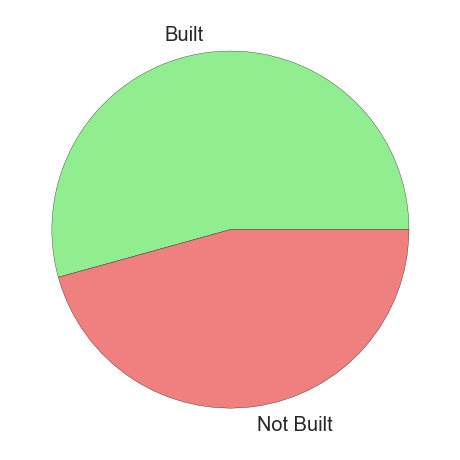

In [132]:
pier.plot(kind='pie', figsize=(8,8), fontsize=20, colors=('lightgreen', 'lightcoral')) # title='August 2013 Newly Permitted Construction')

#### August 2013&mdash;June 2016 newly permitted construction completion times

When did buildings with construction permits issued in August of 2013 actually complete?

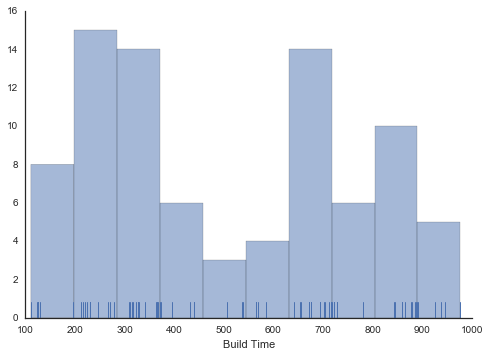

In [131]:
sns.set_style('white')
sns.distplot(sample['Build Time'][sample['Build Time'].notnull()].map(lambda t: t.days),
             bins=10,
             kde=False,
             rug=True,
             hist_kws={'alpha': 0.5},
            )
sns.despine()

The lack of a discernable pattern in this data is surprising, but may simply be the result of a small sample size (with 86 data point in 10 bins, there are just 8.6 observations per bin). To take this further, a larger sample or a full run must be taken.

#### Archiving the data

In [140]:
deduped_new_building_permits.to_csv("new_building_permits.csv")
sample.to_csv("august_2013_sample.csv")

## Briefly&mdash;Site Fill

The following data looks interesting. Perhaps it should be the target of further analysis?

In [135]:
deduped_new_building_permits['Site Fill'].value_counts()

ON-SITE                                     3615
USE UNDER 300 CU.YD                         1805
OFF-SITE                                     701
NONE                                          15
Name: Site Fill, dtype: int64

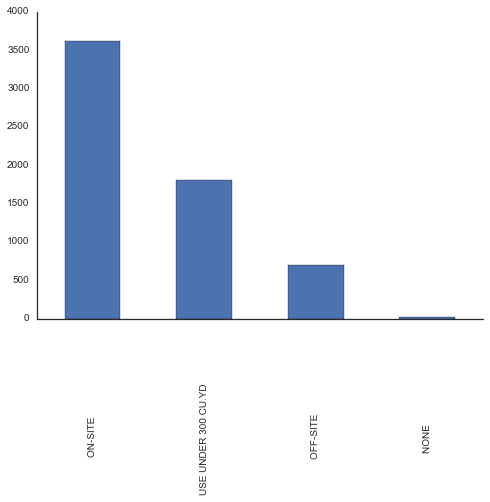

In [138]:
deduped_new_building_permits['Site Fill'].value_counts().plot(kind='bar')
sns.despine()

## Reading Certificate of Occupation Data&mdash;Full Run

The full algorithm takes over a day to run, so I broke it up into intermediate nightly steps.

### Briefly&mdash;Examining Yearly Counts

In [8]:
import pandas as pd
import seaborn as sns
%matplotlib inline

In [6]:
deduped_new_building_permits = pd.read_csv("new_building_permits.csv")

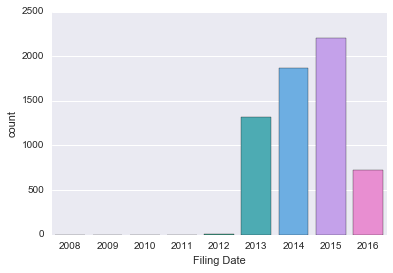

In [9]:
years = deduped_new_building_permits['Filing Date'].map(lambda x: arrow.get(x,"MM/DD/YYYY").year)
sns.countplot(years)

In [10]:
deduped_new_building_permits['Year'] = deduped_new_building_permits['Filing Date'].map(lambda x: arrow.get(x,"MM/DD/YYYY").year)

In [11]:
deduped_new_building_permits[deduped_new_building_permits['Year'] == 2008]

,Unnamed: 0,BOROUGH,Bin #,House #,Street Name,Job #,Job doc. #,Job Type,Self_Cert,Block,...,Owner's First Name,Owner's Last Name,Owner's House #,Owner's House Street Name,Owner’s House City,Owner’s House State,Owner’s House Zip Code,Owner's Phone #,DOBRunDate,Year
4078,336988,BROOKLYN,3855241.0,12749,FLATLANDS AVENUE,302322948.0,1.0,NB,Y,4566.0,...,JOHN,O'CONNELL,85-25,68 ROAD,REGO PARK,NY,11374.0,9.175778e+09,04/30/2015 12:00:00 AM,2008


This entry exhibits that the leading years in the dataset are for permits which had an extremely long lag time between filing and issuance, for unknown reasons.

We can lump the runs into "2013 and earlier", "2014", and "2015", and "2016".

In [12]:
permits_2008_to_2013 = deduped_new_building_permits[deduped_new_building_permits['Year'] <= 2013]
permits_2014 = deduped_new_building_permits[deduped_new_building_permits['Year'] == 2014]
permits_2015 = deduped_new_building_permits[deduped_new_building_permits['Year'] == 2015]
permits_2016 = deduped_new_building_permits[deduped_new_building_permits['Year'] == 2016]

In [13]:
len(permits_2008_to_2013), len(permits_2014), len(permits_2015), len(permits_2016)

(1332, 1869, 2207, 728)

### Algorithm

In [19]:
from tqdm import tqdm
import arrow
import numpy as np
import co_reader

In [15]:
def co_run(df):
    borough_map = {
        'BROOKLYN': 'B',
        'QUEENS': 'Q',
        'STATEN ISLAND': 'R',
        'BRONX': 'X',
        'MANHATTAN': 'M'
    }
    c_of_o_dict = dict()
    counter = 0
    for ind in tqdm((df).iterrows()):
        print("On loop {0}...".format(counter + 1))
        boro = ind[1]['BOROUGH']
        bin = ind[1]['Bin #']
        boro_code = borough_map[boro]
        c_of_o_dict[bin] = co_reader.get_co_date(bin, boro_code)
        counter += 1
    sample = df.copy()
    sample['Certificate Date'] = sample['Bin #'].map(lambda x: c_of_o_dict[x]).values
    sample['Filing Date'] = sample['Filing Date'].map(lambda x: np.datetime64(arrow.get(x,"MM/DD/YYYY").datetime))
    sample['Build Time'] = sample.apply(lambda srs: srs['Certificate Date'] - srs['Filing Date'], axis='columns')
    return sample

In [17]:
# test_run_result = co_run(permits_2008_to_2013.sample(2))

In [18]:
# test_run_result

### First Part&mdash;2013 or earlier

Excepted runtime for this first leg: 6 hours.

In [20]:
leg_2008_to_2013 = co_run(permits_2008_to_2013)

0it [00:00, ?it/s]

On loop 1...
Requested BIN 2818049.0 data from BIS, awaiting response...
Got a response.
Discovered 8 Certificates of Occupancy.
Scanning X000000627.PDF...
PDF Certificate of Occupancy 'X000000627.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning X000004013.PDF...
PDF Certificate of Occupancy 'X000004013.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning X000027982.PDF...
PDF Certificate of Occupancy 'X000027982.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning X000037234.PDF...
PDF Certificate of Occupancy 'X000037234.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 220177350F.PDF...
PDF Certificate of Occupancy '220177350F.PDF' retrieved.
Copying text using optical characte

1it [07:38, 458.27s/it]

['07/01/2015', '07/01/2015', '09/29/2015', '09/29/2015']
Date(s) found!
On loop 2...
Requested BIN 1015907.0 data from BIS, awaiting response...
Got a response.
Discovered 6 Certificates of Occupancy.
Scanning M000005305.PDF...
PDF Certificate of Occupancy 'M000005305.PDF' retrieved.
Copying text using optical character recognition...


KeyboardInterrupt: 